### Generating Images with VAEs and GANs
Implemented two models, a Variational Auto Encoder (VAE) and a Generative Adversarial Network (GAN), each for the task of image generation. Trained these models on Fashion-MNIST, a dataset containing grayscale images of shoes, clothes, hats, etc.

### Variational Auto-Encoder (VAE)

In [1]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Ankle Boot


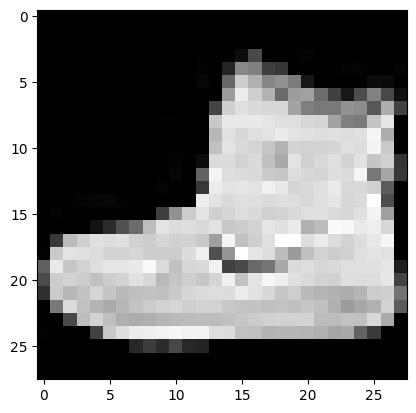

In [3]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

In [ ]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(128 * 7 * 7, 128)
        self.fc_var = nn.Linear(128 * 7 * 7, 128)

        self.decoder_input = nn.Linear(128, 128 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 28x28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)

        z = self.reparameterize(mu, logvar)
        x = self.decoder_input(z)
        x = self.decoder(x)

        return x, mu, logvar

In [ ]:
"""
TRAINING LOOP
"""

"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
"""
for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = net(data)

        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Average loss: {avg_loss:.4f}')


Epoch 1/20, Average loss: 281.2462
Epoch 2/20, Average loss: 250.7884
Epoch 3/20, Average loss: 246.2694
Epoch 4/20, Average loss: 244.1938
Epoch 5/20, Average loss: 242.8322
Epoch 6/20, Average loss: 241.9799
Epoch 7/20, Average loss: 241.2454
Epoch 8/20, Average loss: 240.6985
Epoch 9/20, Average loss: 240.2775
Epoch 10/20, Average loss: 239.9384
Epoch 11/20, Average loss: 239.5798
Epoch 12/20, Average loss: 239.3557
Epoch 13/20, Average loss: 239.1130
Epoch 14/20, Average loss: 238.8453
Epoch 15/20, Average loss: 238.6823
Epoch 16/20, Average loss: 238.5202
Epoch 17/20, Average loss: 238.3435
Epoch 18/20, Average loss: 238.1824
Epoch 19/20, Average loss: 238.0774
Epoch 20/20, Average loss: 237.9198


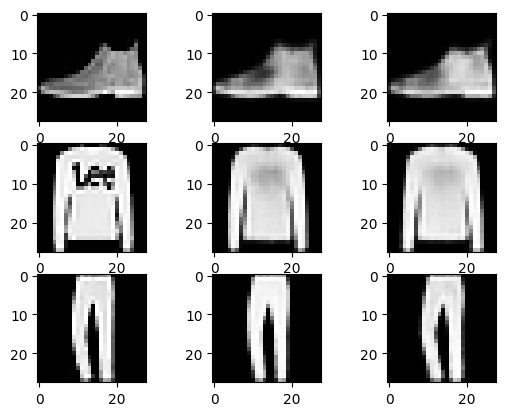

In [ ]:

"""
VISUALIZE OUTPUT

The following part takes two images from test loader to feed into the VAE.
Both the original image and generated image(s) from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np

net.eval()
with torch.no_grad():
    imgs, _ = list(test_loader)[0]
    imgs = imgs.to(device)
    fig, ax = plt.subplots(3,3)
    ax = ax.reshape(-1)
    for i in range(3):
      for j in range(3):
        if j == 0:
          # input image
          img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(img), cmap = 'gray')
        else:
          # vae generation results
          out, mu, logVAR = net(imgs)
          outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(outimg), cmap = 'gray')
    plt.show()


### Generative Adversarial Network (GAN)

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 64, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),

            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, stride=1, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(256 * 7 * 7, 1)),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

In [13]:
"""
TRAINING LOOP
"""

"""
Initialize Hyperparameters
"""
lr = 0.0002
num_epochs = 25

"""
Initialize the network and the Adam optimizer
"""
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.95))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.95))

criterion = nn.BCELoss()

"""
Training loop
"""
for epoch in range(num_epochs):
    g_losses = []
    d_losses = []

    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        real_images = torch.clamp(real_images + 0.05 * torch.randn_like(real_images), 0, 1)

        # Train Discriminator
        d_optimizer.zero_grad()
        label_real = torch.ones(batch_size, 1).to(device)
        label_fake = torch.zeros(batch_size, 1).to(device)

        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, label_real)

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, label_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, label_real)

        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        g_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {np.mean(d_losses):.4f}, g_loss: {np.mean(g_losses):.4f}')

    if (epoch + 1) % 5 == 0:
        fake = generator(torch.randn(9, latent_dim).to(device))

if torch.cuda.is_available():
  torch.cuda.empty_cache()

Epoch [1/25], d_loss: 0.6465, g_loss: 2.5110
Epoch [2/25], d_loss: 0.7954, g_loss: 1.8006
Epoch [3/25], d_loss: 0.8242, g_loss: 1.6950
Epoch [4/25], d_loss: 0.8374, g_loss: 1.6557
Epoch [5/25], d_loss: 0.8772, g_loss: 1.6378
Epoch [6/25], d_loss: 0.8730, g_loss: 1.6012
Epoch [7/25], d_loss: 0.8875, g_loss: 1.5766
Epoch [8/25], d_loss: 0.8791, g_loss: 1.5716
Epoch [9/25], d_loss: 0.8864, g_loss: 1.5616
Epoch [10/25], d_loss: 0.8935, g_loss: 1.5475
Epoch [11/25], d_loss: 0.9014, g_loss: 1.5408
Epoch [12/25], d_loss: 0.9043, g_loss: 1.5353
Epoch [13/25], d_loss: 0.9177, g_loss: 1.5108
Epoch [14/25], d_loss: 0.9333, g_loss: 1.4711
Epoch [15/25], d_loss: 0.9336, g_loss: 1.4742
Epoch [16/25], d_loss: 0.9431, g_loss: 1.4543
Epoch [17/25], d_loss: 0.9524, g_loss: 1.4452
Epoch [18/25], d_loss: 0.9682, g_loss: 1.4267
Epoch [19/25], d_loss: 0.9767, g_loss: 1.4147
Epoch [20/25], d_loss: 0.9800, g_loss: 1.4004
Epoch [21/25], d_loss: 0.9826, g_loss: 1.3848
Epoch [22/25], d_loss: 0.9840, g_loss: 1.38

24


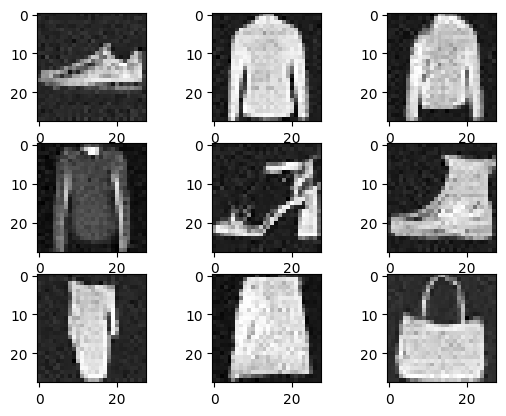

In [20]:
"""
VISUALIZE OUTPUT
"""
print(epoch)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
for i in range(9):
  ax[i].imshow(fake[i,0].cpu().data.numpy(), cmap = 'gray')
plt.show()